In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df=pd.read_csv('AirPassengers.csv')
df=df.rename(columns={'#Passengers':'passengers','Month':'date'})
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)
df=df.drop(columns=['date'])
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# CHECK FOR NULL VALUES
df.isnull().sum()

passengers    0
dtype: int64

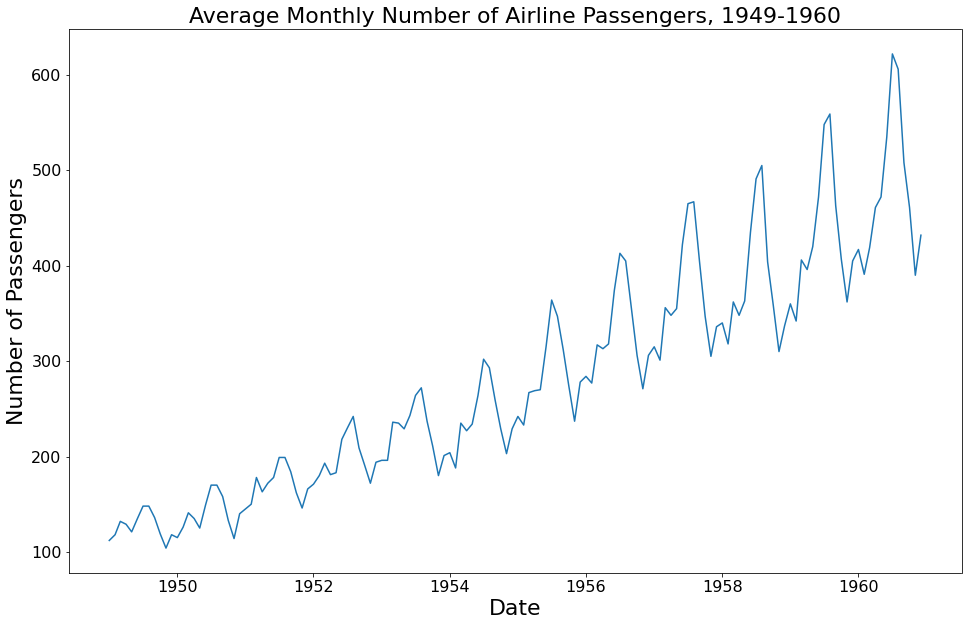

In [4]:
# Set figure size
plt.figure(figsize=(16,10))

# Create Line Plot
plt.plot(df['passengers'])

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Number of Passengers', fontsize=22)
plt.title('Average Monthly Number of Airline Passengers, 1949-1960', fontsize=22);

Text(0.5, 1.0, 'Distribution of Passengers')

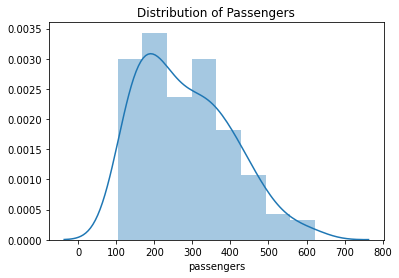

In [5]:
sns.distplot(df['passengers'])
plt.title('Distribution of Passengers')

<Figure size 432x288 with 0 Axes>

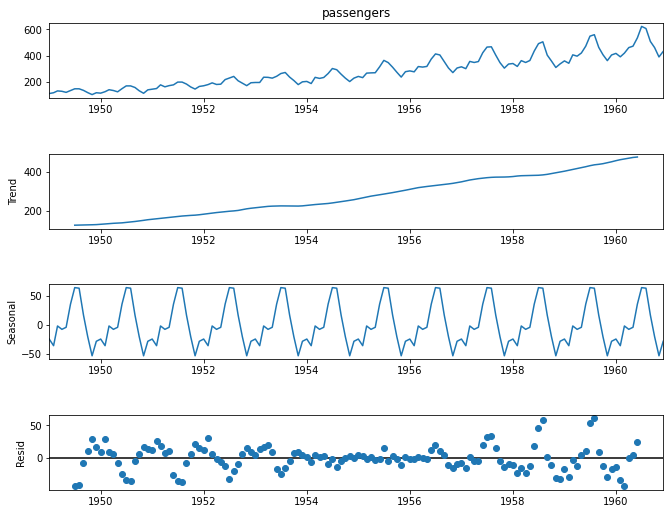

In [32]:
seasonal = seasonal_decompose(df.passengers,period=12)
fig = plt.figure()  
fig = seasonal.plot()  
fig.set_size_inches(10, 8)

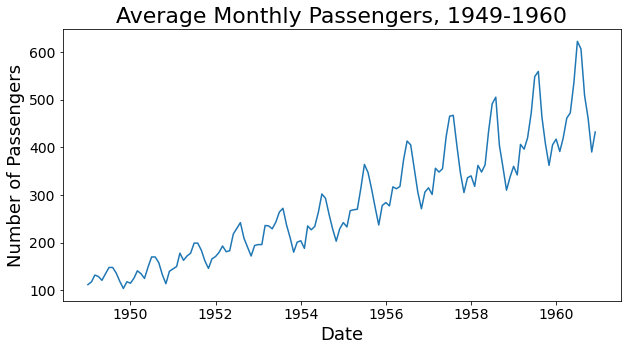

In [8]:
# Set figure size
plt.figure(figsize=(10,5))

# rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# Create Line Plot
plt.plot(df['passengers'])

# Set labels and title.
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Passengers', fontsize=18)
plt.title('Average Monthly Passengers, 1949-1960', fontsize=22);

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.

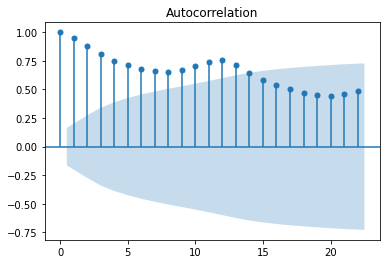

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['passengers']);


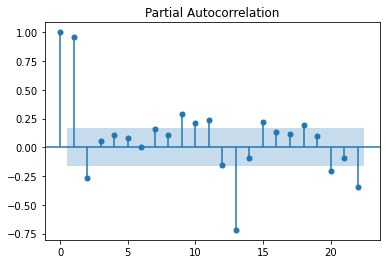

In [15]:
plot_pacf(df['passengers']);


In [16]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['passengers']))

Test Statistic    0.815369
p-value           0.991880
dtype: float64

Since $\alpha$ < p-value = 0.18, we cannot reject the null hypothesis. So, I will take the difference and perform the test again.

In [17]:
interpret_dftest(adfuller(df['passengers'].diff(1).dropna()))


Test Statistic   -2.829267
p-value           0.054213
dtype: float64

In [18]:
interpret_dftest(adfuller(df['passengers'].diff(2).dropna()))

Test Statistic   -2.961695
p-value           0.038630
dtype: float64

Since $\alpha$ > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data by setting the difference hyperparameter to 1.

Let's look at the ACF/ PACF plots using the differenced data to visualize the lags that will likely be influencial when modeling the price.

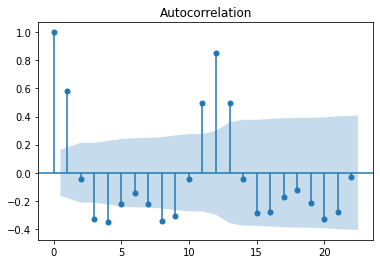

In [37]:
plot_acf(df['passengers'].diff(2).dropna());

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


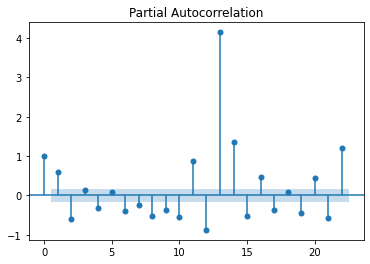

In [20]:
plot_pacf(df['passengers'].diff(2).dropna());

In [21]:
train = df[df.index<'1958-01-01']
test = df[df.index>='1958-01-01']

In [31]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
# Iterating over values of p and q.
for p in range(5):
    for q in range(5):
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 2, {q}) model.')
            # Instantiate ARIMA model.
            arima = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
                          order = (p, 2, q))
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},2,{q}) is: {model.aic}')
            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},2,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 2, 0) model.
The AIC for ARIMA(0,2,0) is: 1032.960749896368
Attempting to fit ARIMA(0, 2, 1) model.
The AIC for ARIMA(0,2,1) is: 1001.1511626361234
Attempting to fit ARIMA(0, 2, 2) model.
The AIC for ARIMA(0,2,2) is: 989.3863385520431
Attempting to fit ARIMA(0, 2, 3) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided

The AIC for ARIMA(0,2,3) is: 987.4868486681157
Attempting to fit ARIMA(0, 2, 4) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for ARIMA(0,2,4) is: 976.4989018506849
Attempting to fit ARIMA(1, 2, 0) model.
The AIC for ARIMA(1,2,0) is: 1030.6804656724685
Attempting to fit ARIMA(1, 2, 1) model.
Attempting to fit ARIMA(1, 2, 2) model.
The AIC for ARIMA(1,2,2) is: 986.7148898415905
Attempting to fit ARIMA(1, 2, 3) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided

The AIC for ARIMA(1,2,3) is: 987.7525914116268
Attempting to fit ARIMA(1, 2, 4) model.
The AIC for ARIMA(1,2,4) is: 989.5239227814648
Attempting to fit ARIMA(2, 2, 0) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided

The AIC for ARIMA(2,2,0) is: 1021.9858987085788
Attempting to fit ARIMA(2, 2, 1) model.
The AIC for ARIMA(2,2,1) is: 989.9928100372726
Attempting to fit ARIMA(2, 2, 2) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for ARIMA(2,2,2) is: 988.0973935100005
Attempting to fit ARIMA(2, 2, 3) model.
The AIC for ARIMA(2,2,3) is: 989.6993418699149
Attempting to fit ARIMA(2, 2, 4) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, 

The AIC for ARIMA(2,2,4) is: 975.6732976326716
Attempting to fit ARIMA(3, 2, 0) model.
The AIC for ARIMA(3,2,0) is: 1022.8600948015649
Attempting to fit ARIMA(3, 2, 1) model.
The AIC for ARIMA(3,2,1) is: 991.0832024932229
Attempting to fit ARIMA(3, 2, 2) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for ARIMA(3,2,2) is: 988.4736337817758
Attempting to fit ARIMA(3, 2, 3) model.
Attempting to fit ARIMA(3, 2, 4) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp

The AIC for ARIMA(3,2,4) is: 964.2580751101582
Attempting to fit ARIMA(4, 2, 0) model.
The AIC for ARIMA(4,2,0) is: 1006.3722139995418
Attempting to fit ARIMA(4, 2, 1) model.
The AIC for ARIMA(4,2,1) is: 981.3785988003935
Attempting to fit ARIMA(4, 2, 2) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for ARIMA(4,2,2) is: 985.2758108525027
Attempting to fit ARIMA(4, 2, 3) model.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, 

The AIC for ARIMA(4,2,3) is: 968.3254498141953
Attempting to fit ARIMA(4, 2, 4) model.
The AIC for ARIMA(4,2,4) is: 976.9755423386898


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,2,4).
This model has an AIC of 964.2580751101582.


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(endog = train.astype(float).dropna(),
              order = (3,2,4))
arima = model.fit()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [25]:
forecast, stderr, conf_int = arima.forecast(len(test), alpha = 0.05)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f'MAE = {mean_absolute_error(test, forecast)}')


MAE = 51.72622171327302


In [27]:
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D2.passengers   No. Observations:                  106
Model:                 ARIMA(3, 2, 4)   Log Likelihood                -473.129
Method:                       css-mle   S.D. of innovations             19.836
Date:                Mon, 04 Jan 2021   AIC                            964.258
Time:                        17:32:07   BIC                            988.229
Sample:                    03-01-1949   HQIC                           973.974
                         - 12-01-1957                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0014      0.079      0.018      0.986      -0.154       0.157
ar.L1.D2.passengers     0.2620      0.095      2.754      0.006       0.076       0.448
ar.L2.D2.passengers    -0.2616      0.094     -2.776      0.005      -0.446      -0.077
ar.L3.D2.passengers    -0.7187      0.093     -7.731      0.000      -0.901      -0.537
ma.L1.D2.passengers    -0.9230      0.073    -12.577      0.000      -1.067      -0.779
ma.L2.D2.passengers     0.0827      0.100      0.826      0.409      -0.114       0.279
ma.L3.D2.passengers     0.7963      0.098      8.129      0.000       0.604       0.988
ma.L4.D2.passengers    -0.9560      0.068    -14.075      0.000      -1.089      -0.823
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5033           -0.8728j            1.0075           -0.1667
AR.2            0.5033           +0.8728j            1.0075            0.1667
AR.3           -1.3706           -0.0000j            1.3706           -0.5000
MA.1           -1.0460           -0.0000j            1.0460           -0.5000
MA.2            0.4395           -0.8982j            1.0000           -0.1776
MA.3            0.4395           +0.8982j            1.0000            0.1776
MA.4            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

In [28]:
resid = test['passengers']-forecast


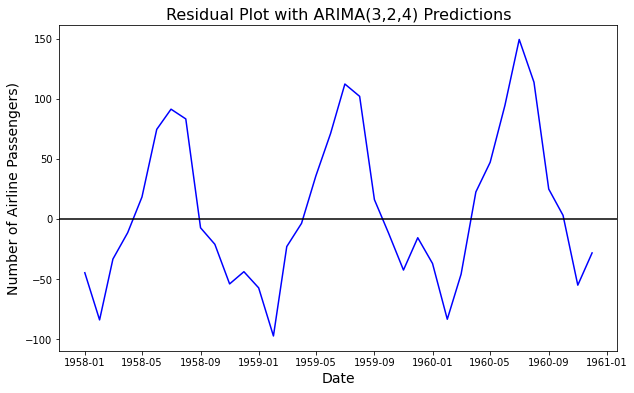

In [38]:

plt.figure(figsize=(10,6))
plt.plot(resid,color = 'blue') 
plt.ylabel('Number of Airline Passengers)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(3,2,4) Predictions', fontsize=16) 
plt.axhline(0, color = 'k', ls = '-')
plt.show();

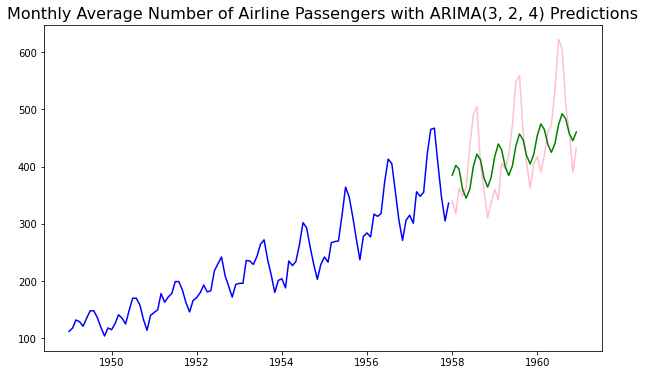

In [44]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['passengers'], color = 'blue', label = 'Training Number of Passengers')

# Plot testing data.
plt.plot(test.index, test['passengers'], color = 'pink', label = 'Actual Number of Passengers')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

plt.title(label = 'Monthly Average Number of Airline Passengers with ARIMA(3, 2, 4) Predictions', fontsize=16);